# Purpose
The purpose of this notebook is to consolidate categorical features from `data/immo_data_202208.csv` in one column each.

# Summary  

| Feature       | Complete Data found in/with                                                               |  
| ------------- | ----------------------------------------------------------------------------------------- |  
| Municipality  | RegEx `address` with `\d{4} (.+?),`                                                       |  
| Zip Code      | RegEx `address` with `(\d{4}) [A-ZÀ-Ÿ]`                                                   |  
| Canton        | RegEx `address` `, ?([A-ZÀ-Ÿ]{2})`                                                        |  
| Street        | RegEx `address` `(.+), \d{4}`, drop 3874 and set street from 12362 to `Rte de la Jorette` |  
| Street Number | RegEx `^.+ (\d.+)` from above prepared `street`                                           |  
| Availability  | Join `Availability_merged` and `detail_responsive#available_from`                         |

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings

warnings.filterwarnings("ignore")


In [2]:
# Import DataFarme
df = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immo_data_202208.csv",
    low_memory=False,
)


# Address

We discovered that the following columns contain information about the address of an object:
- `Commune`
- `Comune`
- `Gemeinde`
- `Municipality`
- `Municipality_merged`
- `detail_responvice#municipality`
- `address`
- `Locality`
- `location`
- `location_parsed`
- `table`
- `details_structured`
- `Zip`

In [3]:
# Select relevant columns
cols_address = [
    "Municipality",
    "Gemeinde",
    "Commune",
    "Comune",
    "detail_responsive#municipality",
    "Municipality_merged",
    "location",
    "location_parsed",
    "address",
    "Locality",
    "Zip",
]
df_address = df.loc[:, cols_address]


In [4]:
df_address


,Municipality,Gemeinde,Commune,Comune,detail_responsive#municipality,Municipality_merged,location,location_parsed,address,Locality,Zip
0,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"5023 Biberstein, AG",Strasse: plz:5023 Stadt: Biberstein Kanton: AG,"5023 Biberstein, AG",Biberstein,5023
1,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"Buhldenstrasse 8d5023 Biberstein, AG",Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Buhldenstrasse 8d, 5023 Biberstein, AG",Biberstein,5023
2,NaN,NaN,NaN,NaN,Küttigen,NaN,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Aarau,5000
3,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"Buhaldenstrasse 8A5023 Biberstein, AG",Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...,"Buhaldenstrasse 8A, 5023 Biberstein, AG",Biberstein,5023
4,Küttigen,NaN,NaN,NaN,NaN,Küttigen,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Rombach,5022
...,...,...,...,...,...,...,...,...,...,...,...
13373,Uster,NaN,NaN,NaN,NaN,Uster,"Tägerackerstrasse 138610 Uster, ZH",Strasse:Tägerackerstrasse 13 plz:8610 Stadt: ...,"Tägerackerstrasse 13, 8610 Uster, ZH",Uster,8610
13374,Volketswil,NaN,NaN,NaN,NaN,Volketswil,"8604 Volketswil, ZH",Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,"8604 Volketswil, ZH",Volketswil,8604
13375,Seuzach,NaN,NaN,NaN,NaN,Seuzach,"8472 Seuzach, ZH",Strasse: plz:8472 Stadt: Seuzach Kanton: ZH,"8472 Seuzach, ZH",Hettlingen,8442
13376,Zell (ZH),NaN,NaN,NaN,NaN,Zell (ZH),"Vordere Bähntalstrasse 18483 Kollbrunn, ZH",Strasse:Vordere Bähntalstrasse 1 plz:8483 Sta...,"Vordere Bähntalstrasse 1, 8483 Kollbrunn, ZH",Weisslingen,8484


## Municipality and postal code

First we'll figure out how to extract the municipality and postal code together since they're dependent.

In [5]:
# RegEx to extract municipality and postal code

# municipality
# From table
df_address["municip_from_table"] = df["table"].str.extract(
    "Municipality.+?rJZBK####>(.+?)<\/td>"
)
# From details_structured
df_address["municip_from_details_structured"] = df["details_structured"].str.extract(
    "'Municipality': ?'(.+?)'"
)
# From location
df_address["municip_from_location"] = df_address["location"].str.extract(
    r"\d{4} (.+?),"
)
# From address
df_address["municip_from_address"] = df_address["address"].str.extract(r"\d{4} (.+?),")
# From location_parsed
df_address["municip_from_location_parsed"] = df_address["location_parsed"].str.extract(
    r"Stadt: ?(.+?) K"
)

# Postal code
# From address
df_address["plz_from_address"] = df["address"].str.extract(r"(\d{4}) [A-ZÀ-Ÿ]")
# From location
df_address["plz_from_location"] = df["location"].str.extract("(\d{4}) [A-ZÀ-Ÿ]")
# From location_parsed
df_address["plz_from_location_parsed"] = df["location_parsed"].str.extract(
    "plz: ?(\d+)"
)


### NA Heatmap
The following heatmap shows the missing values of the selected data and can therefore give some good insight on where the complete data can be found.

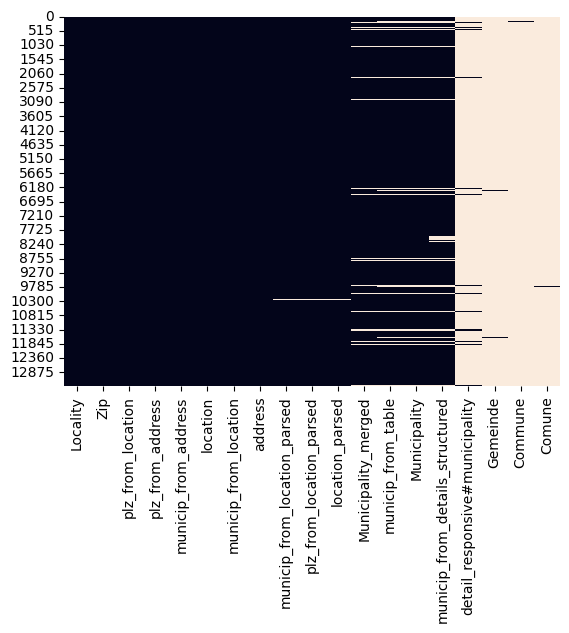

In [6]:
# Sort columns by number of non-null values
df_address = df_address.reindex(
    df_address.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_address.isna(), cbar=False)
plt.show()


From this plot and the column names we can assume that `Municipality`, `Gemeinde`, `Commune`, `Comune` and `detail_responsive#municipality` merged together could form a decent combination of values for the municipality.

In [7]:
# Merge Municipality, Gemeinde, Commune, Comune, detail_responsive#municipality
df_address["Municipality"] = df_address["Municipality"].fillna(df_address["Gemeinde"])
df_address["Municipality"] = df_address["Municipality"].fillna(df_address["Commune"])
df_address["Municipality"] = df_address["Municipality"].fillna(df_address["Comune"])
df_address["Municipality"] = df_address["Municipality"].fillna(
    df_address["detail_responsive#municipality"]
)

df_address.drop(
    ["Gemeinde", "Commune", "Comune", "detail_responsive#municipality"],
    axis=1,
    inplace=True,
)


In [8]:
# Select rows where from_table and from_details_structured are not equal
df_address[
    df_address["municip_from_table"].fillna("")
    != df_address["municip_from_details_structured"].fillna("")
]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality_merged,municip_from_table,Municipality,municip_from_details_structured
4,Rombach,5022,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen,K&#252;ttigen,Küttigen,Küttigen
43,Rombach,5022,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen,K&#252;ttigen,Küttigen,Küttigen
47,Rombach,5022,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen,K&#252;ttigen,Küttigen,Küttigen
51,Rombach,5022,5022,5022,Rombach,"Bibersteinerstrasse 805022 Rombach, AG",Rombach,"Bibersteinerstrasse 80, 5022 Rombach, AG",Rombach,5022,Strasse:Bibersteinerstrasse 80 plz:5022 Stadt...,Küttigen,K&#252;ttigen,Küttigen,Küttigen
55,Küttigen,5024,5022,5022,Rombach,"Waldweg5022 Rombach, AG",Rombach,"Waldweg, 5022 Rombach, AG",Rombach,5022,Strasse: Waldweg plz:5022 Stadt: Rombach Kanto...,Küttigen,K&#252;ttigen,Küttigen,Küttigen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13291,Pfaffhausen,8118,8118,8118,Pfaffhausen,"Pfaffhausen8118 Pfaffhausen, ZH",Pfaffhausen,"Pfaffhausen, 8118 Pfaffhausen, ZH",Pfaffhausen,8118,Strasse: Pfaffhausen plz:8118 Stadt: Pfaffhaus...,Fällanden,F&#228;llanden,Fällanden,Fällanden
13293,Wallisellen,8304,8044,8044,Gockhausen,"Im Langwil8044 Gockhausen, ZH",Gockhausen,"Im Langwil, 8044 Gockhausen, ZH",Gockhausen,8044,Strasse:Im Langwil plz:8044 Stadt: Gockhausen...,"Dübendorf, Kreis 7 (Zurich)","D&#252;bendorf, Kreis 7 (Zurich)","Dübendorf, Kreis 7 (Zurich)","Dübendorf, Kreis 7 (Zurich)"
13295,Pfaffhausen,8118,8118,8118,Pfaffhausen,"Pfaffensteinstrasse 358118 Pfaffhausen, ZH",Pfaffhausen,"Pfaffensteinstrasse 35, 8118 Pfaffhausen, ZH",Pfaffhausen,8118,Strasse:Pfaffensteinstrasse 35 plz:8118 Stadt...,Fällanden,F&#228;llanden,Fällanden,Fällanden
13297,Winterthur,8408,8044,8044,Zürich,"Zürich8044 Zürich, ZH",Zürich,"Zürich, 8044 Zürich, ZH",Zürich,8044,Strasse: rich plz:8044 Stadt: Zürich Kanton: ZH,"Zürich, Kreis 6 (Zurich)","Z&#252;rich, Kreis 6 (Zurich)","Zürich, Kreis 6 (Zurich)","Zürich, Kreis 6 (Zurich)"


The above table shows all observations where `municip_from_table` is not equal to `municip_from_details_structured`. The data extracted from `table` (column `municip_from_table`) suffers from encoding issues and seems to not provide more information than other columns so we discard it.  
Also it looks like there's some inconsistency in the data and we note that `Locality`, `municip_from_location` and `municip_from_location_parsed` contain the same information as does `Municipality_merged`, `municip_from_table`, `Municipality` and `municip_from_details_structured` (at least in the here shown data).  

We also note that in row 13295 all postal code columns have a value of 8118 which is the code for Pfaffhausen (checked [here](https://www.post.ch/de/pages/plz-suche)). Fällanden has the postal code 8117 so the information in `Municipality_merged`, `municip_from_table`, `Municipality` and `municip_from_details_structured` seems to be off. 

Row 13297 shows postal code 8044 which is Gockhausen. Row 13298 has postal code 8121 which is Benglen so it seems that `Zip` and `Locality` contain incorrect information. 

In [9]:
df_address.drop("municip_from_table", axis=1, inplace=True)


In [10]:
# Select rows where Municipality and from_details_structured are not equal
df_address[
    df_address["Municipality"].fillna("")
    != df_address["municip_from_details_structured"].fillna("")
]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality_merged,Municipality,municip_from_details_structured
2,Aarau,5000,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,NaN,Küttigen,NaN
21,Erlinsbach,5018,5018,5018,Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,5018,Strasse: plz:5018 Stadt: Erlinsbach Kanton: AG,Erlinsbach (AG),Erlinsbach (AG),NaN
36,Hirschthal,5042,5042,5042,Hirschthal,"Hirschthal5042 Hirschthal, AG",Hirschthal,"Hirschthal, 5042 Hirschthal, AG",Hirschthal,5042,Strasse: Hirschthal plz:5042 Stadt: Hirschthal...,Hirschthal,Hirschthal,NaN
39,Aarau,5000,5004,5004,Aarau,"Rütmattstrasse 175004 Aarau, AG",Aarau,"Rütmattstrasse 17, 5004 Aarau, AG",Aarau,5004,Strasse:Rütmattstrasse 17 plz:5004 Stadt: Aar...,NaN,Aarau,NaN
44,Hirschthal,5042,5042,5042,Hirschthal,"5042 Hirschthal, AG",Hirschthal,"5042 Hirschthal, AG",Hirschthal,5042,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,NaN,Hirschthal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13356,Hettlingen,8442,8442,8442,Hettlingen,"Mitteldorfstrasse 88442 Hettlingen, ZH",Hettlingen,"Mitteldorfstrasse 8, 8442 Hettlingen, ZH",Hettlingen,8442,Strasse:Mitteldorfstrasse 8 plz:8442 Stadt: H...,NaN,Hettlingen,NaN
13357,Winterthur,8400,8400,8400,Winterthur,"Loorstrasse 298400 Winterthur, ZH",Winterthur,"Loorstrasse 29, 8400 Winterthur, ZH",Winterthur,8400,Strasse:Loorstrasse 29 plz:8400 Stadt: Winter...,NaN,Winterthur,NaN
13359,Volketswil,8604,8604,8604,Volketswil,"8604 Volketswil, ZH",Volketswil,"8604 Volketswil, ZH",Volketswil,8604,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,NaN,Volketswil,NaN
13363,Winterthur,8405,8405,8405,Winterthur,"Zum Hölzli 178405 Winterthur, ZH",Winterthur,"Zum Hölzli 17, 8405 Winterthur, ZH",Winterthur,8405,Strasse:Zum Hölzli 17 plz:8405 Stadt: Wintert...,NaN,Winterthur,NaN


The above output shows observations where `Municipality` is not equal to `municip_from_details_structured` and suggests that `Municipality_merged` and `municip_from_details_structured` are missing information where other columns do not.

In [11]:
df_address[df_address["municip_from_details_structured"].isna()]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality_merged,Municipality,municip_from_details_structured
2,Aarau,5000,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,NaN,Küttigen,NaN
21,Erlinsbach,5018,5018,5018,Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,5018,Strasse: plz:5018 Stadt: Erlinsbach Kanton: AG,Erlinsbach (AG),Erlinsbach (AG),NaN
36,Hirschthal,5042,5042,5042,Hirschthal,"Hirschthal5042 Hirschthal, AG",Hirschthal,"Hirschthal, 5042 Hirschthal, AG",Hirschthal,5042,Strasse: Hirschthal plz:5042 Stadt: Hirschthal...,Hirschthal,Hirschthal,NaN
39,Aarau,5000,5004,5004,Aarau,"Rütmattstrasse 175004 Aarau, AG",Aarau,"Rütmattstrasse 17, 5004 Aarau, AG",Aarau,5004,Strasse:Rütmattstrasse 17 plz:5004 Stadt: Aar...,NaN,Aarau,NaN
44,Hirschthal,5042,5042,5042,Hirschthal,"5042 Hirschthal, AG",Hirschthal,"5042 Hirschthal, AG",Hirschthal,5042,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,NaN,Hirschthal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13356,Hettlingen,8442,8442,8442,Hettlingen,"Mitteldorfstrasse 88442 Hettlingen, ZH",Hettlingen,"Mitteldorfstrasse 8, 8442 Hettlingen, ZH",Hettlingen,8442,Strasse:Mitteldorfstrasse 8 plz:8442 Stadt: H...,NaN,Hettlingen,NaN
13357,Winterthur,8400,8400,8400,Winterthur,"Loorstrasse 298400 Winterthur, ZH",Winterthur,"Loorstrasse 29, 8400 Winterthur, ZH",Winterthur,8400,Strasse:Loorstrasse 29 plz:8400 Stadt: Winter...,NaN,Winterthur,NaN
13359,Volketswil,8604,8604,8604,Volketswil,"8604 Volketswil, ZH",Volketswil,"8604 Volketswil, ZH",Volketswil,8604,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,NaN,Volketswil,NaN
13363,Winterthur,8405,8405,8405,Winterthur,"Zum Hölzli 178405 Winterthur, ZH",Winterthur,"Zum Hölzli 17, 8405 Winterthur, ZH",Winterthur,8405,Strasse:Zum Hölzli 17 plz:8405 Stadt: Wintert...,NaN,Winterthur,NaN


In [12]:
df_address[df_address["Municipality_merged"].isna()]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality_merged,Municipality,municip_from_details_structured
2,Aarau,5000,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,NaN,Küttigen,NaN
39,Aarau,5000,5004,5004,Aarau,"Rütmattstrasse 175004 Aarau, AG",Aarau,"Rütmattstrasse 17, 5004 Aarau, AG",Aarau,5004,Strasse:Rütmattstrasse 17 plz:5004 Stadt: Aar...,NaN,Aarau,NaN
44,Hirschthal,5042,5042,5042,Hirschthal,"5042 Hirschthal, AG",Hirschthal,"5042 Hirschthal, AG",Hirschthal,5042,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,NaN,Hirschthal,NaN
53,Hirschthal,5042,5042,5042,Hirschthal,"5042 Hirschthal, AG",Hirschthal,"5042 Hirschthal, AG",Hirschthal,5042,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,NaN,Hirschthal,NaN
170,Baden,5400,5400,5400,Baden,"Mellingerstrasse 1705400 Baden, AG",Baden,"Mellingerstrasse 170, 5400 Baden, AG",Baden,5400,Strasse:Mellingerstrasse 170 plz:5400 Stadt: ...,NaN,Baden,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13351,Pfungen,8422,8422,8422,Pfungen,"Breiteackerstrasse8422 Pfungen, ZH",Pfungen,"Breiteackerstrasse, 8422 Pfungen, ZH",Pfungen,8422,Strasse: Breiteackerstrasse plz:8422 Stadt: Pf...,NaN,Pfungen,NaN
13356,Hettlingen,8442,8442,8442,Hettlingen,"Mitteldorfstrasse 88442 Hettlingen, ZH",Hettlingen,"Mitteldorfstrasse 8, 8442 Hettlingen, ZH",Hettlingen,8442,Strasse:Mitteldorfstrasse 8 plz:8442 Stadt: H...,NaN,Hettlingen,NaN
13357,Winterthur,8400,8400,8400,Winterthur,"Loorstrasse 298400 Winterthur, ZH",Winterthur,"Loorstrasse 29, 8400 Winterthur, ZH",Winterthur,8400,Strasse:Loorstrasse 29 plz:8400 Stadt: Winter...,NaN,Winterthur,NaN
13359,Volketswil,8604,8604,8604,Volketswil,"8604 Volketswil, ZH",Volketswil,"8604 Volketswil, ZH",Volketswil,8604,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,NaN,Volketswil,NaN


They both contain many missing values, so we discard them as well. 

In [13]:
df_address.drop(
    ["Municipality_merged", "municip_from_details_structured"], axis=1, inplace=True
)


In [14]:
# Select rows where Municipality and Locality are not equal
df_address[df_address["Municipality"].fillna("") != df_address["Locality"].fillna("")]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality
2,Aarau,5000,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen
4,Rombach,5022,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen
5,Erlinsbach,5018,5018,5018,Erlinsbach,"Buchhalde 365018 Erlinsbach, AG",Erlinsbach,"Buchhalde 36, 5018 Erlinsbach, AG",Erlinsbach,5018,Strasse:Buchhalde 36 plz:5018 Stadt: Erlinsba...,Erlinsbach (AG)
8,Aarau Rohr,5032,5032,5032,Aarau Rohr,"Siebenmatten 495032 Aarau Rohr, AG",Aarau Rohr,"Siebenmatten 49, 5032 Aarau Rohr, AG",Aarau Rohr,5032,Strasse:Siebenmatten 49 plz:5032 Stadt: Aarau...,Aarau
9,Erlinsbach,5018,5018,5018,Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,5018,Strasse: plz:5018 Stadt: Erlinsbach Kanton: AG,Erlinsbach (AG)
...,...,...,...,...,...,...,...,...,...,...,...,...
13321,Wermatswil,8615,8615,8615,Freudwil,"8615 Freudwil, ZH",Freudwil,"8615 Freudwil, ZH",Freudwil,8615,Strasse: plz:8615 Stadt: Freudwil Kanton: ZH,Uster
13323,Wermatswil,8615,8615,8615,Wermatswil,"Leubergstrasse 218615 Wermatswil, ZH",Wermatswil,"Leubergstrasse 21, 8615 Wermatswil, ZH",Wermatswil,8615,Strasse:Leubergstrasse 21 plz:8615 Stadt: Wer...,Uster
13326,Wermatswil,8615,8615,8615,Wermatswil,"Leubergstrasse 218615 Wermatswil, ZH",Wermatswil,"Leubergstrasse 21, 8615 Wermatswil, ZH",Wermatswil,8615,Strasse:Leubergstrasse 21 plz:8615 Stadt: Wer...,Uster
13375,Hettlingen,8442,8472,8472,Seuzach,"8472 Seuzach, ZH",Seuzach,"8472 Seuzach, ZH",Seuzach,8472,Strasse: plz:8472 Stadt: Seuzach Kanton: ZH,Seuzach


This above table shows observations where `Municipality` is not equal to `Locality`. It shows that there's conflicting information concerning the municipality and we note that `Locality` and `Municipality` do not match with the data given in `location`, `address` and `location_parsed`. 

In [15]:
df_address[
    (df_address["municip_from_location"].notna())
    & (df_address["municip_from_location_parsed"].isna())
]


,Locality,Zip,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality
3874,Winterthur,8405,4160,4160,COLLONGES SOUS SALEVE,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,COLLONGES SOUS SALEVE1256 Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,NaN,Troinex
4096,Winterthur,8405,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4097,Winterthur,8405,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4098,Winterthur,8405,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4226,Winterthur,8405,7032,7032,Laax GR 2,"Via Brutg 237032 Laax GR 2, GR",Laax GR 2,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4229,Winterthur,8405,7032,7032,Laax GR 2,"Via Brutg 237032 Laax GR 2, GR",Laax GR 2,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4232,Winterthur,8405,7032,7032,Laax GR 2,"Via Cuolm Liung 307032 Laax GR 2, GR",Laax GR 2,"Via Cuolm Liung 30, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4235,Winterthur,8405,7032,7032,Laax GR 2,"7032 Laax GR 2, GR",Laax GR 2,"7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
10234,Winterthur,8405,1000,1000,Lausanne 26,"1000 Lausanne 26, VD",Lausanne 26,"1000 Lausanne 26, VD",NaN,NaN,NaN,Lausanne
10237,Winterthur,8405,1000,1000,Lausanne 26,"1000 Lausanne 26, VD",Lausanne 26,"1000 Lausanne 26, VD",NaN,NaN,NaN,Lausanne


This table which shows rows where `municip_from_location` is not `na` and `municip_from_location_parsed` is. It suggests that in some cases the parsing which filled `location_parsed` didn't work. Also in these cases, `Locality` and `Zip` seem to just fallback to «Winterthur» and 8405, so we drop them. 

In [16]:
df_address.drop(["Locality", "Zip"], axis=1, inplace=True)


In [17]:
# Select rows where from_location and from_location_parsed are not equal
df_address[
    df_address["municip_from_location"].fillna("")
    != df_address["municip_from_location_parsed"].fillna("")
]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality
13,5033,5033,Buchs AG,"Steinfeldstrasse 485033 Buchs AG, AG",Buchs AG,"Steinfeldstrasse 48, 5033 Buchs AG, AG",Buchs,5033,Strasse:Steinfeldstrasse 48 plz:5033 Stadt: B...,Buchs (AG)
17,5033,5033,Buchs AG,"Grenzweg 25033 Buchs AG, AG",Buchs AG,"Grenzweg 2, 5033 Buchs AG, AG",Buchs,5033,Strasse:Grenzweg 2 plz:5033 Stadt: Buchs Kant...,Buchs (AG)
19,5033,5033,Buchs AG,"Trieschweg 265033 Buchs AG, AG",Buchs AG,"Trieschweg 26, 5033 Buchs AG, AG",Buchs,5033,Strasse:Trieschweg 26 plz:5033 Stadt: Buchs K...,Buchs (AG)
27,5033,5033,Buchs AG,"Steinfeldstrasse 485033 Buchs AG, AG",Buchs AG,"Steinfeldstrasse 48, 5033 Buchs AG, AG",Buchs,5033,Strasse:Steinfeldstrasse 48 plz:5033 Stadt: B...,Buchs (AG)
29,5033,5033,Buchs AG,"Grenzweg 25033 Buchs AG, AG",Buchs AG,"Grenzweg 2, 5033 Buchs AG, AG",Buchs,5033,Strasse:Grenzweg 2 plz:5033 Stadt: Buchs Kant...,Buchs (AG)
...,...,...,...,...,...,...,...,...,...,...
13226,8703,8703,Erlenbach ZH,"Lerchenbergstrasse 93B8703 Erlenbach ZH, ZH",Erlenbach ZH,"Lerchenbergstrasse 93B, 8703 Erlenbach ZH, ZH",Erlenbach,8703,Strasse:Lerchenbergstrasse 93B plz:8703 Stadt...,Erlenbach (ZH)
13228,8703,8703,Erlenbach ZH,"Kappelistrasse 28703 Erlenbach ZH, ZH",Erlenbach ZH,"Kappelistrasse 2, 8703 Erlenbach ZH, ZH",Erlenbach,8703,Strasse:Kappelistrasse 2 plz:8703 Stadt: Erle...,Erlenbach (ZH)
13230,8703,8703,Erlenbach ZH,"Obstgartenweg 28703 Erlenbach ZH, ZH",Erlenbach ZH,"Obstgartenweg 2, 8703 Erlenbach ZH, ZH",Erlenbach,8703,Strasse:Obstgartenweg 2 plz:8703 Stadt: Erlen...,Erlenbach (ZH)
13232,8703,8703,Erlenbach ZH,"8703 Erlenbach ZH, ZH",Erlenbach ZH,"8703 Erlenbach ZH, ZH",Erlenbach,8703,Strasse: plz:8703 Stadt: Erlenbach Kanton: ZH,Erlenbach (ZH)


In [18]:
df_address[df_address["municip_from_location"].isna()]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality


In [19]:
df_address[df_address["municip_from_location_parsed"].isna()]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality
3874,4160,4160,COLLONGES SOUS SALEVE,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,COLLONGES SOUS SALEVE1256 Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN,NaN,Troinex
4096,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4097,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4098,7514,7514,Sils/Segl Maria,"7514 Sils/Segl Maria, GR",Sils/Segl Maria,"7514 Sils/Segl Maria, GR",NaN,NaN,NaN,Sils im Engadin/Segl
4226,7032,7032,Laax GR 2,"Via Brutg 237032 Laax GR 2, GR",Laax GR 2,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4229,7032,7032,Laax GR 2,"Via Brutg 237032 Laax GR 2, GR",Laax GR 2,"Via Brutg 23, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4232,7032,7032,Laax GR 2,"Via Cuolm Liung 307032 Laax GR 2, GR",Laax GR 2,"Via Cuolm Liung 30, 7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
4235,7032,7032,Laax GR 2,"7032 Laax GR 2, GR",Laax GR 2,"7032 Laax GR 2, GR",NaN,NaN,NaN,Laax
10234,1000,1000,Lausanne 26,"1000 Lausanne 26, VD",Lausanne 26,"1000 Lausanne 26, VD",NaN,NaN,NaN,Lausanne
10237,1000,1000,Lausanne 26,"1000 Lausanne 26, VD",Lausanne 26,"1000 Lausanne 26, VD",NaN,NaN,NaN,Lausanne


This comparison shows that `municip_from_location` does not contain missing values but includes the canton. The column `municip_from_location_parsed` does not include the canton but has missing values.  

In [20]:
df_address[df_address["Municipality"] != df_address["municip_from_location"]]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,municip_from_location_parsed,plz_from_location_parsed,location_parsed,Municipality
2,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen
4,5022,5022,Rombach,"5022 Rombach, AG",Rombach,"5022 Rombach, AG",Rombach,5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG,Küttigen
5,5018,5018,Erlinsbach,"Buchhalde 365018 Erlinsbach, AG",Erlinsbach,"Buchhalde 36, 5018 Erlinsbach, AG",Erlinsbach,5018,Strasse:Buchhalde 36 plz:5018 Stadt: Erlinsba...,Erlinsbach (AG)
8,5032,5032,Aarau Rohr,"Siebenmatten 495032 Aarau Rohr, AG",Aarau Rohr,"Siebenmatten 49, 5032 Aarau Rohr, AG",Aarau Rohr,5032,Strasse:Siebenmatten 49 plz:5032 Stadt: Aarau...,Aarau
9,5018,5018,Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,"5018 Erlinsbach, AG",Erlinsbach,5018,Strasse: plz:5018 Stadt: Erlinsbach Kanton: AG,Erlinsbach (AG)
...,...,...,...,...,...,...,...,...,...,...
13320,8606,8606,Nänikon,"8606 Nänikon, ZH",Nänikon,"8606 Nänikon, ZH",Nänikon,8606,Strasse: plz:8606 Stadt: Nänikon Kanton: ZH,Uster
13321,8615,8615,Freudwil,"8615 Freudwil, ZH",Freudwil,"8615 Freudwil, ZH",Freudwil,8615,Strasse: plz:8615 Stadt: Freudwil Kanton: ZH,Uster
13323,8615,8615,Wermatswil,"Leubergstrasse 218615 Wermatswil, ZH",Wermatswil,"Leubergstrasse 21, 8615 Wermatswil, ZH",Wermatswil,8615,Strasse:Leubergstrasse 21 plz:8615 Stadt: Wer...,Uster
13326,8615,8615,Wermatswil,"Leubergstrasse 218615 Wermatswil, ZH",Wermatswil,"Leubergstrasse 21, 8615 Wermatswil, ZH",Wermatswil,8615,Strasse:Leubergstrasse 21 plz:8615 Stadt: Wer...,Uster


From this output it's clear that `Municipality` is incorrect for some rows so we drop it as well as `municip_from_location_parsed`.

In [21]:
df_address.drop(["Municipality", "municip_from_location_parsed"], axis=1, inplace=True)


In [22]:
df_address[df_address["municip_from_address"] != df_address["municip_from_location"]]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,plz_from_location_parsed,location_parsed
3181,1669,1669,Les Sciernes-d'Albeuve,"1669 Les Sciernes-d Albeuve, FR",Les Sciernes-d Albeuve,"1669 Les Sciernes-d'Albeuve, FR",1669,Strasse: plz:1669 Stadt: Les Sciernes-d Albeu...
3184,1669,1669,Les Sciernes-d'Albeuve,Rue Champ la Vuille1669 Les Sciernes-d Albeuve...,Les Sciernes-d Albeuve,"Rue Champ la Vuille, 1669 Les Sciernes-d'Albeu...",1669,Strasse:Rue Champ la Vuille plz:1669 Stadt: L...
3199,1669,1669,Les Sciernes-d'Albeuve,"1669 Les Sciernes-d Albeuve, FR",Les Sciernes-d Albeuve,"1669 Les Sciernes-d'Albeuve, FR",1669,Strasse: plz:1669 Stadt: Les Sciernes-d Albeu...
3874,4160,4160,COLLONGES SOUS SALEVE,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,COLLONGES SOUS SALEVE1256 Troinex,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,NaN
10198,1454,1454,L'Auberson,"1454 L Auberson, VD",L Auberson,"1454 L'Auberson, VD",1454,Strasse: plz:1454 Stadt: L Auberson Kanton: VD
10294,1522,1522,Lucens,5a avenue de la Vignette 1522 Lucens1000 Lausa...,Lucens1000 Lausanne,"5a avenue de la Vignette 1522 Lucens, 1000 Lau...",1000,Strasse: Lucens plz:1000 Stadt: Lausanne Kanto...
11755,1961,1961,Vernamiège,"Route des Condémines, 1961 Vernamiège1973 Nax, VS",Vernamiège1973 Nax,"Route des Condémines, 1961 Vernamiège, 1973 Na...",1973,Strasse: ge plz:1973 Stadt: Nax Kanton: VS
12135,1873,1873,Val-d'Illiez,"1873 Val-d Illiez, VS",Val-d Illiez,"1873 Val-d'Illiez, VS",1873,Strasse: plz:1873 Stadt: Val-d Illiez Kanton: VS
12148,1873,1873,Val-d'Illiez,"1873 Val-d Illiez, VS",Val-d Illiez,"1873 Val-d'Illiez, VS",1873,Strasse: plz:1873 Stadt: Val-d Illiez Kanton: VS
12153,1873,1873,Val-d'Illiez,"1873 Val-d Illiez, VS",Val-d Illiez,"1873 Val-d'Illiez, VS",1873,Strasse: plz:1873 Stadt: Val-d Illiez Kanton: VS


It seems that `municip_from_address` and `municip_from_location` contain the same information but `municip_from_address` includes the more accurate format.

In [23]:
df_address[df_address["municip_from_address"].isna()]


,plz_from_location,plz_from_address,municip_from_address,location,municip_from_location,address,plz_from_location_parsed,location_parsed


There are also no missing values in `municip_from_address` so we choose to use it for our data on municipality. 

In [24]:
df_address.drop(["municip_from_location"], axis=1, inplace=True)


In [25]:
# Rename municipality
df_address.rename(columns={"municip_from_address": "municipality"}, inplace=True)
df_address


,plz_from_location,plz_from_address,municipality,location,address,plz_from_location_parsed,location_parsed
0,5023,5023,Biberstein,"5023 Biberstein, AG","5023 Biberstein, AG",5023,Strasse: plz:5023 Stadt: Biberstein Kanton: AG
1,5023,5023,Biberstein,"Buhldenstrasse 8d5023 Biberstein, AG","Buhldenstrasse 8d, 5023 Biberstein, AG",5023,Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...
2,5022,5022,Rombach,"5022 Rombach, AG","5022 Rombach, AG",5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG
3,5023,5023,Biberstein,"Buhaldenstrasse 8A5023 Biberstein, AG","Buhaldenstrasse 8A, 5023 Biberstein, AG",5023,Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...
4,5022,5022,Rombach,"5022 Rombach, AG","5022 Rombach, AG",5022,Strasse: plz:5022 Stadt: Rombach Kanton: AG
...,...,...,...,...,...,...,...
13373,8610,8610,Uster,"Tägerackerstrasse 138610 Uster, ZH","Tägerackerstrasse 13, 8610 Uster, ZH",8610,Strasse:Tägerackerstrasse 13 plz:8610 Stadt: ...
13374,8604,8604,Volketswil,"8604 Volketswil, ZH","8604 Volketswil, ZH",8604,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH
13375,8472,8472,Seuzach,"8472 Seuzach, ZH","8472 Seuzach, ZH",8472,Strasse: plz:8472 Stadt: Seuzach Kanton: ZH
13376,8483,8483,Kollbrunn,"Vordere Bähntalstrasse 18483 Kollbrunn, ZH","Vordere Bähntalstrasse 1, 8483 Kollbrunn, ZH",8483,Strasse:Vordere Bähntalstrasse 1 plz:8483 Sta...


## PLZ

Since we're extracting the municipality from `address` we find it best to do the same for the postal code so we can ensure consistency within the two columns.

In [26]:
df_address[df_address["plz_from_address"].isna()]


,plz_from_location,plz_from_address,municipality,location,address,plz_from_location_parsed,location_parsed


There are no missing values in `plz_from_address` but to make sure we've got clean data, we'll verify the postal codes with a list of postal codes in switzerland provided by [postleitzahlenschweiz.ch](https://postleitzahlenschweiz.ch/tabelle/):

In [27]:
df_xlsx_plz = pd.read_excel("../../eda/utils/plz.xlsx", sheet_name="Blatt1")


FileNotFoundError: [Errno 2] No such file or directory: '../../eda/utils/plz.xlsx'

In [ ]:
df_xlsx_plz.drop(
    ["Kanton", "Canton", "Cantone", "Land", "Pays", "Paese"], axis=1, inplace=True
)
df_xlsx_plz.rename(
    columns={
        df_xlsx_plz.columns[0]: "plz",
        df_xlsx_plz.columns[1]: "municipality",
        df_xlsx_plz.columns[2]: "kanton",
    },
    inplace=True,
)


In [ ]:
df_xlsx_plz


In [ ]:
# Show if rows from 'plz_from_address' are found in 'df_xlsx_plz'
df_address["plz_from_address"] = df_address["plz_from_address"].astype(int)
df_address["plz_from_address"].isin(df_xlsx_plz["plz"]).value_counts()


The above statement shows that there is 1 postal code in `plz_from_address` that cannot be verified with the list provided by postleitzahlenschweiz.ch.

In [ ]:
df_address[~df_address["plz_from_address"].isin(df_xlsx_plz["plz"])]


It appears to be an object located in france which explains the issue. Since objects in france are not part of the sampled population we drop it. 

In [ ]:
# Drop row 3874
df_address.drop(3874, inplace=True)


In [ ]:
df_address.drop(["plz_from_location", "plz_from_location_parsed"], axis=1, inplace=True)


In [ ]:
df_address


## Canton

We can also extract the canton from `address`:

In [ ]:
df_address["canton"] = df_address["address"].str.extract(r", ?([A-ZÀ-Ÿ]{2})")


In [ ]:
df_address[~df_address["canton"].isin(df_xlsx_plz["kanton"])]


In [ ]:
df_address[df_address["canton"].isna()]


## Street
We collect all address data from the column `address` so to keep the consistency, it's best to do the same for the street but we'll compare it to other sources nevertheless. 

In [ ]:
df_address["street_from_address"] = df_address["address"].str.extract(r"(.+), \d{4}")
df_address["street_from_location_parsed"] = (
    df_address["location_parsed"]
    .str.extract(r"^Strasse:(.+?) plz")
    .replace(" ", np.nan)
)

df_address["street_from_location"] = df_address["location"].str.extract(r"(.+)\d{4} ")


In [ ]:
df_address


In [ ]:
# Show where columns are na but 'from_address' is not na
df_address[df_address.isna().any(axis=1) & df_address["street_from_address"].notna()]


The RegEx to extract street data from `address`, `location` and `location_parsed` seems to work ok but we find that `location` and `address` contains street data where `location_parsed` does not, so we use `street_from_address`. Though there are some incorrect values that need to be cleaned up.

In [ ]:
# Get index of rows where columns are na but 'from_address' is not na
list_index = df_address[
    df_address.isna().any(axis=1) & df_address["street_from_address"].notna()
].index


In [ ]:
# Cleanup 'from_address' and 'from_location_parsed' columns
df_address.loc[df_address["street_from_address"] == "-", "street_from_address"] = np.nan
df_address.loc[df_address["street_from_address"] == "à", "street_from_address"] = np.nan


We also noticed that the street in row 12362 «Résidence "Le Cleuset"» is no street name. With a quick Google search we find that this property is on the street «Rte de la Jorette».

In [ ]:
df_address.iloc[12362]


In [ ]:
df_address.loc[12363, "street_from_address"] = "Rte de la Jorette"


In [ ]:
# Print rows where columns are na but 'from_address' is not na again
df_address.iloc[list_index]


In [ ]:
df_address.drop(
    [
        "street_from_location_parsed",
        "street_from_location",
        "location",
        "address",
        "location_parsed",
    ],
    axis=1,
    inplace=True,
)


In [ ]:
df_address


In [ ]:
# Separate the street and number
df_address["street_nr"] = df_address["street_from_address"].str.extract(r"^.+ (\d.+)")
df_address["street"] = df_address["street_from_address"].str.extract(r"^(.+?) \d")
df_address["street"] = df_address["street"].str.rstrip()

df_address.drop(
    [
        "street_from_address",
    ],
    axis=1,
    inplace=True,
)


In [ ]:
df_address


# Availability
Data on the availability of a property can be found in the following columns:

- `Availability`
- `Availability_merged`
- `Disponibilità`
- `Disponibilité`
- `Verfügbarkeit`
- `detail_responsive#available_from`
- `details_structured`
- `table`

In [ ]:
# Prepare dataframe to handle availability data
cols_availability = [
    "Availability",
    "Verfügbarkeit",
    "Disponibilité",
    "Disponibilità",
    "detail_responsive#available_from",
    "Availability_merged",
]

df_availability = df.loc[:, cols_availability]
df_availability["from_details_structured"] = df["details_structured"].str.extract(
    r"'Availability': '(.+?)'"
)


Like with columns we analysed in [this](./3-daw_quantitative.html) notebook we find that the column `Availability_merged` consists of the data from `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`:

In [ ]:
df_availability.iloc[:, 0:5].count().cumsum() == df_availability.iloc[:, 5].count()


## NA Heatmap

In [ ]:
# Sort columns by number of non-null values
df_availability = df_availability.reindex(
    df_availability.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_availability.isna(), cbar=False)
plt.show()


In [ ]:
# Merge columns `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`
df_availability["availability"] = (
    df_availability[cols_availability[0]]
    .fillna(df_availability[cols_availability[1]])
    .fillna(df_availability[cols_availability[2]])
    .fillna(df_availability[cols_availability[3]])
)

# Compare 'availability' with 'Availability_merged'
(
    df_availability["availability"].fillna("")
    == df_availability[cols_availability[5]].fillna("")
).sum() == df.shape[0]


We can confirm, that the column `Availability_merged` contains all information from the columns `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`. Merging `detail_responsive#available_from` adds more data.

In [ ]:
# Merge columns `availability` and `detail_responsive#available_from`
df_availability["availability"] = df_availability[cols_availability[5]].fillna(
    df_availability[cols_availability[4]]
)

df_availability["availability"].count()


And with that we've got complete data on the availability.

In [ ]:
# Clean up df_availability
df_availability.drop(
    [
        "Availability",
        "Verfügbarkeit",
        "Disponibilité",
        "Disponibilità",
        "detail_responsive#available_from",
        "Availability_merged",
        "from_details_structured",
    ],
    axis=1,
    inplace=True,
)
df_availability
